In [2]:
import re
import sys
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from nltk.tokenize import word_tokenize
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from emoji import emoji_count
import statistics as stat
import nltk
from nltk.corpus import cess_esp
import os
import json
import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [14]:
URLS_RE = re.compile(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*')

LISTING_RE = re.compile(r'^(|[a-z]?|[0-9]{0,3})(\-|\.)+( |\n)')

def remove_urls(text):
    return URLS_RE.sub('', text)

def replace_multi_whitespaces(line):
    return ' '.join(line.split())

def remove_listing(line):
    return LISTING_RE.sub('', line)

def remove_punctuation(text):
    text = text.replace('!','')
    text = text.replace('"','')
    return text.translate(str.maketrans('','',string.punctuation))

def quitar_guiones(text):
    aux = text.split('--')
    aux2 = []
    for w in aux:
        if len(w)>0:
            text = replace_multi_whitespaces(w)
            aux2.append(text)
    return '\n'.join(aux2)

def quitar_tags(text):
    tags = 'LOC|NUM|TIEM|PER'
    regex = re.compile(tags,re.S)
    res = regex.sub('', text)
    return res.replace('<','')

def remove_stopwords(text,stop_words):
    words = text.split(' ')
    not_stop_words = []
    for word in words:
        if word not in stop_words:
            not_stop_words.append(word)
    return ' '.join(not_stop_words)
      

def clean_text(text,stop_words):	

    low = text.lower()
    rem_u = remove_urls(low)
    rem_l = remove_listing(rem_u)
    rem_t = quitar_tags(rem_l)
    rem_w = replace_multi_whitespaces(rem_t)
    rem_p = remove_punctuation(rem_w)
    rem_s = remove_stopwords(rem_p,stop_words)
    text_enc = rem_s.encode('ascii', 'ignore')

    return text_enc.decode()

def tagger():
    oraciones = cess_esp.tagged_sents()
    return nltk.UnigramTagger(oraciones)

def load_sentiment_analysis():
    sent_analysis_data = pd.read_csv('../Spanish-NRC-EmoLex.txt',sep='\t')
    spanish_dict = list(sent_analysis_data['Spanish Word'])
    negative_cols = ['negative','fear','anger','disgust','sadness']
    positive_cols = ['positive','joy','trust']

    negative_words = []
    for col in negative_cols:
        i = 0
        for val in sent_analysis_data[col]:
            if val == 1:
                negative_words.append(spanish_dict[i])
            i += 1

    positive_words = []
    for col in positive_cols:
        i = 0
        for val in sent_analysis_data[col]:
            if val == 1:
                positive_words.append(spanish_dict[i])
            i += 1

    return set(positive_words),set(negative_words)

def sent_analysis(words,positive_words,negative_words):

    intersection_neg = list(negative_words & set(words))
    intersection_pos = list(positive_words & set(words))

    return len(intersection_pos),len(intersection_neg)

# returns a list of words that occur exactly 'num' times or None if no coincidence
def num_occurences(lista,num):
    aux_dict = {}
    for item in lista:
        if item in aux_dict.keys():
            aux_dict[item] += 1
        else:
            aux_dict[item] = 1

    try:
        idx = list(aux_dict.values()).index(num)
        words = list(aux_dict.keys())[idx]
        return len(words)
    except:
        return 0
    

def get_edad(fn,file):
    # fn del denunciante
    if '/' not in fn:
        if len(fn) != 8:
            return -1
        year = fn[:4]
        month = fn[4:6]
        day = fn[6:]
    else:
        aux = fn.split('/')
        if len(aux) != 3:
            return -1
        
        day = aux[0]
        month = aux[1]
        year = aux[-1]
    
    try:
        fecha = datetime.date(int(year),int(month),int(day))
    except:
        print(file)
    diff = relativedelta(datetime.date.today(),fecha).years

    if diff < 25:
        edad = '18-24'
    elif diff < 35:
        edad = '25-34'
    elif diff < 45:
        edad = '35-44'
    elif diff < 55:
        edad = '45-54'
    else:
        edad = '+55'
    return edad
        
def get_region(provincia):
    
    df = pd.read_excel('Tabla Provincias.xls')
    ccaa = list(df.loc[df['Nombre Provincia'].str.contains(provincia.upper())]['Nombre CCAA'])
    if len(ccaa) == 0:
        return provincia
    
    return ccaa[0]

def data_scaler(data):
    scaler = StandardScaler()
    x = data.values
    cols = data.columns
    x_scaled = scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled,columns=cols)
    return df

def save_results(y_test,y_pred,average,tunning=False,params=None,remove=False):

    acc = accuracy_score(y_test,y_pred)
    prec = precision_score(y_test,y_pred,average=average)
    rec = recall_score(y_test,y_pred,average=average)
    f1 = f1_score(y_test,y_pred,average=average)

    if remove:
        rem = 'Without outliers'
    else:
        rem = 'With outliers'

    if tunning:
        sent = f'\t\t\t* With tunning & {rem}: {params}\n'
    else:
        sent = f'\t\t\t* Without tunning & {rem}:\n'

    with open('resultados_policia.txt','a') as f:
        f.write(sent)
        f.write(f'\t\t\t\t-> Accuracy: {acc}\n')
        f.write(f'\t\t\t\t-> Precision: {prec}\n')
        f.write(f'\t\t\t\t-> Recall: {rec}\n')
        f.write(f'\t\t\t\t-> F1-score: {f1}\n')

In [4]:
stop_words_df = pd.read_csv('../spanish-stop-words.txt',header=None)
stop_words = list(stop_words_df[0]) + ['q','ma']

files = os.listdir('Atestados')
files.remove('.DS_Store')

In [5]:
df = pd.DataFrame()

In [6]:
positive_words,negative_words = load_sentiment_analysis()

## Denunciante DF

In [7]:
paises = pd.read_excel('../paises_estandar.xls')
paises['Continente'] = [s.translate(str.maketrans('', '', string.digits)) for s in paises['Continente']]
paises.head()

,Continente,Código,País o territorio
0,UNIÓN EUROPEA,102,AUSTRIA
1,UNIÓN EUROPEA,103,BELGICA
2,UNIÓN EUROPEA,104,BULGARIA
3,UNIÓN EUROPEA,106,CHIPRE
4,UNIÓN EUROPEA,107,DINAMARCA


In [8]:
from geopy.geocoders import Nominatim 
from string import digits
geolocator = Nominatim(user_agent="preprocessing")

denunciante_df = pd.DataFrame()  

list_genero = []
list_region = []
list_edad = [] 

files_with_errors = []
paises_hispanohablantes = ['Argentina', 'Bolivia', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Ecuador', 'El Salvador', 'Guatemala', 'Guinea Ecuatorial', 'Honduras', 'México', 'Nicaragua', 'Panamá', 'Uruguay', 'Perú', 'Puerto Rico', 'República Dominicana', 'Uruguay', 'Venezuela']

i = 0
for file in files:
    with open(f'Atestados/{file}') as f:
        _dict = json.load(f)
        # denunciante
        denunciante = _dict['denunciante']
        provincia = denunciante['provincia'].title()
        genero = denunciante['sexo']
        fn = denunciante['fn']
        # obtener comunidad autonoma
        try:
            location = geolocator.geocode(provincia,language='es').raw['display_name']
            location = location.translate(str.maketrans('', '', digits))
            location_aux = [l for l in location.split(', ') if len(l)>0]

            if len(location_aux) == 1:
                if location_aux[-1] == 'España':
                    region = 'Comunidad de Madrid'
                elif location_aux[-1] in paises_hispanohablantes:
                    region = 'LATINOS'
                else:
                    region = paises.loc[paises[' País o  territorio'] == location_aux[-1].upper()]['Continente'].item()

            else:
                ccaa = location_aux[-2]
                pais = location_aux[-1]
                if pais != 'España':
                    if pais in paises_hispanohablantes:
                        region = 'LATINOS'
                    else:
                        region = paises.loc[paises[' País o  territorio'] == location_aux[-1].upper()]['Continente'].item()
                else:
                    region = ccaa

            edad = get_edad(fn,file)
            if edad == -1:
                files_with_errors.append(file)
            else:
                list_genero.append(genero)
                list_edad.append(edad)
                list_region.append(region)
        except:
            files_with_errors.append(file)

    i += 1
    print(f'{i} de {len(files)}')

denunciante_df['gender'] = list_genero
denunciante_df['age'] = list_edad
denunciante_df['region'] = list_region

1 de 3898
2 de 3898
3 de 3898
4 de 3898
5 de 3898
6 de 3898
7 de 3898
8 de 3898
9 de 3898
10 de 3898
11 de 3898
12 de 3898
13 de 3898
14 de 3898
15 de 3898
16 de 3898
17 de 3898
18 de 3898
19 de 3898
20 de 3898
21 de 3898
22 de 3898
23 de 3898
24 de 3898
25 de 3898
26 de 3898
27 de 3898
28 de 3898
29 de 3898
30 de 3898
31 de 3898
32 de 3898
33 de 3898
34 de 3898
35 de 3898
36 de 3898
37 de 3898
38 de 3898
39 de 3898
40 de 3898
41 de 3898
42 de 3898
43 de 3898
44 de 3898
45 de 3898
46 de 3898
47 de 3898
48 de 3898
49 de 3898
50 de 3898
51 de 3898
52 de 3898
53 de 3898
54 de 3898
55 de 3898
56 de 3898
57 de 3898
58 de 3898
59 de 3898
60 de 3898
61 de 3898
62 de 3898
63 de 3898
64 de 3898
65 de 3898
66 de 3898
67 de 3898
68 de 3898
69 de 3898
70 de 3898
71 de 3898
72 de 3898
73 de 3898
74 de 3898
75 de 3898
76 de 3898
77 de 3898
78 de 3898
79 de 3898
80 de 3898
81 de 3898
82 de 3898
83 de 3898
84 de 3898
85 de 3898
86 de 3898
87 de 3898
88 de 3898
89 de 3898
90 de 3898
91 de 3898
92 de 38

## Policia DF

In [7]:
policia_df = pd.DataFrame()  

list_genero = []
list_region = []
list_edad = [] 

for file in files:
    with open(f'Atestados/{file}') as f:
        _dict = json.load(f)
        # policia
        policia = _dict['cp']
        provincia = policia['provincia'].title()
        genero = policia['sexo']
        fn = policia['fn']
        region = get_region(provincia)
        edad = get_edad(fn,file)

        list_genero.append(genero)
        list_edad.append(edad)
        list_region.append(region)

policia_df['gender'] = list_genero
policia_df['age'] = list_edad
policia_df['region'] = list_region

In [148]:
policia_df.head()

,gender,age,region
0,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA
1,H,35-44,COMUNIDAD VALENCIANA
2,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA
3,H,25-34,COMUNIDAD VALENCIANA
4,H,35-44,PRINCIPADO DE ASTURIAS


In [41]:
denunciante_df.head()

,gender,age,region
0,H,25-34,Andalucía
1,M,+55,Castilla-La Mancha
2,M,25-34,Latino
3,M,+55,No hispanohablante
4,M,+55,Comunitat Valenciana


In [8]:
# remove files with errors
files = [file for file in files if file not in files_with_errors]

NameError: name 'files_with_errors' is not defined

In [11]:
# load data for character based features analysis
def df_character_based():
    data = pd.DataFrame()    
    punctuation_list = list(string.punctuation)

    num_char = []
    num_capital = []
    num_punctuation = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            text = quitar_tags(text)
            text = quitar_guiones(text)
            cleaned_text = replace_multi_whitespaces(text)
            num_char.append(len(cleaned_text))
            num_capital.append(sum(1 for c in cleaned_text if c.isupper()))
            num_punctuation.append(sum(1 for c in cleaned_text if c in punctuation_list))
    
    data['characters'] = num_char
    data['capital_letters'] = num_capital
    data['punctuations'] = num_punctuation

    data = data_scaler(data)

    return pd.concat([policia_df,data],axis=1)

In [12]:
df_char = df_character_based()
df_char.head()

,gender,age,region,characters,capital_letters,punctuations
0,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA,-1.018301,-0.612236,-0.863065
1,H,35-44,COMUNIDAD VALENCIANA,-0.285184,-0.574428,-0.234397
2,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA,-0.535402,-0.322377,-0.593636
3,H,25-34,COMUNIDAD VALENCIANA,0.912125,0.837057,2.055750
4,H,35-44,PRINCIPADO DE ASTURIAS,3.406127,2.273748,3.402896


In [13]:
from imblearn.over_sampling import SMOTE

In [75]:
def exec(df,features,target_col,model,remove,feature_type):
    # remove outliers
    if features is None:
        features = [str(i) for i in range(300)]
    else:
        if remove:
            # remove outliers
            for f in features:
                Q1 = np.percentile(df[f],25,method = 'midpoint')
                Q3 = np.percentile(df[f],75,method = 'midpoint')
                IQR = Q3 - Q1
                upper = Q3 + 1.5*IQR
                lower = Q1 - 1.5*IQR
                drop_index = np.where(df[f]>=upper) + np.where(df[f]<=lower)
                df.drop(drop_index[0], inplace=True)
                df.reset_index(drop=True,inplace=True)

        if feature_type == 'all':
            features += [str(i) for i in range(300)]

    for t in df[target_col].unique():
        if len(df.loc[df[target_col] == t]) < 2:
            df = df.loc[df[target_col] != t]
            df.reset_index(drop=True,inplace=True)

    target = df[target_col]
    col_drop = [f for f in df.columns if f not in features]
    df.drop(col_drop,axis=1,inplace=True)

    oversample = SMOTE()
    X, y = oversample.fit_resample(df, target)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True,test_size=0.2,random_state=109)

    average = 'weighted'
    if target_col == 'gender':
        objective = 'binary:logistic'
    else:
        objective = 'multi:softmax'

    if model == 'svm':
        clf = svm.SVC() 
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        save_results(y_test,y_pred,average,remove=remove)
        print('results without tunning saved')

        params = "{'C': 10, 'gamma': 1, 'kernel': 'rbf'}"
        clf = svm.SVC(C=10,gamma=1,kernel='rbf')
        clf.fit(X_train, y_train)
    
    elif model == 'rf':
        clf = RandomForestClassifier()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        save_results(y_test,y_pred,average,remove=remove)
        print('results without tunning saved')

        params="{'criterion': 'gini', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}"
        clf = RandomForestClassifier(criterion='gini',max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=4,n_estimators=200)
        clf.fit(X_train, y_train)
        
    elif model == 'xgboost':
        clf = xgb.XGBRFClassifier(objective=objective)
        clf.fit(X_train, y_train)
        feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
        feat_importances.nlargest(20).plot(kind='barh')
        y_pred = clf.predict(X_test)
        save_results(y_test,y_pred,average,remove=remove)
        print('results without tunning saved')

        params = "{'learning_rate': 0.01, 'n_estimators': 100, 'reg_lambda': 0.5}"
        clf = xgb.XGBRFClassifier(objective=objective,learning_rate=0.01,n_estimators=100,reg_lambda=0.5)
        clf.fit(X_train, y_train)
        
    y_pred = clf.predict(X_test)
    save_results(y_test,y_pred,average,tunning=True,params=params,remove=remove)

    return 'OK'


In [16]:
gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_char['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_char['region'].unique():
    region_dict[region] = i
    i += 1

df_char['gender'] = df_char['gender'].map(gender_dict)
df_char['age'] = df_char['age'].map(age_dict)
df_char['region'] = df_char['region'].map(region_dict)
df_char.head()

,gender,age,region,characters,capital_letters,punctuations
0,1,0,0,-1.018301,-0.612236,-0.863065
1,1,0,1,-0.285184,-0.574428,-0.234397
2,1,0,0,-0.535402,-0.322377,-0.593636
3,1,1,1,0.912125,0.837057,2.055750
4,1,0,2,3.406127,2.273748,3.402896


results without tunning saved


'OK'

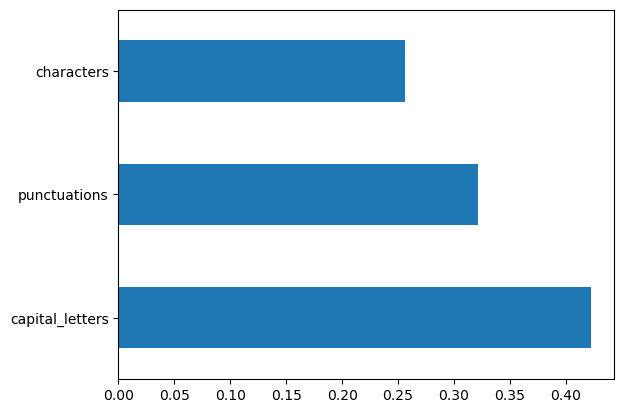

In [50]:
df_char_gender = df_char.copy()
exec(df_char_gender,['characters','capital_letters','punctuations'],'gender','xgboost',remove=False,feature_type='emb')

In [31]:
df_char_gender = df_char.copy()
exec(df_char_gender,['characters','capital_letters','punctuations'],'age','rf',remove=False,feature_type='emb')

results without tunning saved
Counter({4: 504, 3: 498, 1: 495, 0: 392, 2: 377})


'OK'

In [ ]:
df_char_gender = df_char.copy()
exec(df_char_gender,['characters','capital_letters','punctuations'],'region','svm',remove=False,feature_type='emb')

In [32]:
# load data for character based features analysis
def df_structural_based():    
    data = pd.DataFrame()   
    num_sentence = []
    av_sentence_par = []
    av_words_par = []
    av_char_par = []
    variation = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            text = quitar_tags(text)
            text = quitar_guiones(text)
            cleaned_text = replace_multi_whitespaces(text)

            num_par = len(cleaned_text.split('\n'))

            cleaned_text = cleaned_text.replace('\n','')
            sentences = cleaned_text.split('.')
            num_sentence_user = len(sentences)
            num_sentence.append(num_sentence_user)
            av_sentence_par.append(num_sentence_user/num_par)
            
            words = [w for w in cleaned_text.split(' ') if len(w) > 0]
            num_words = len(words)
            av_words_par.append(num_words/num_par)
            av_char_par.append(len(cleaned_text)/num_par)

            len_sentence_list = [len(sentence) for sentence in sentences]
            if len(len_sentence_list) > 1:
                var = stat.variance(len_sentence_list)
            else:
                var = 0
            variation.append(var)     


    data['num_sentence'] = num_sentence
    data['av_sentence_par'] = av_sentence_par
    data['av_words_par'] = av_words_par
    data['av_char_par'] = av_char_par
    data['variation'] = variation

    data = data_scaler(data)

    return pd.concat([policia_df,data],axis=1)

In [33]:
df_struct = df_structural_based()
df_struct = df_struct.loc[df_struct['region'] != 'República Dominicana']
df_struct.reset_index(drop=True, inplace=True)

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_struct['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_struct['region'].unique():
    region_dict[region] = i
    i += 1

df_struct['gender'] = df_struct['gender'].map(gender_dict)
df_struct['age'] = df_struct['age'].map(age_dict)
df_struct['region'] = df_struct['region'].map(region_dict)

df_struct.head()

,gender,age,region,num_sentence,av_sentence_par,av_words_par,av_char_par,variation
0,1,0,0,-0.943521,-0.943521,-1.055831,-1.018301,-0.212517
1,1,0,1,-0.453163,-0.453163,-0.266230,-0.285184,-0.334263
2,1,0,0,-0.453163,-0.453163,-0.536179,-0.535402,-0.304757
3,1,1,1,2.488981,2.488981,0.840561,0.912125,-0.431431
4,1,0,2,3.633149,3.633149,3.405077,3.406127,0.204904


results without tunning saved


'OK'

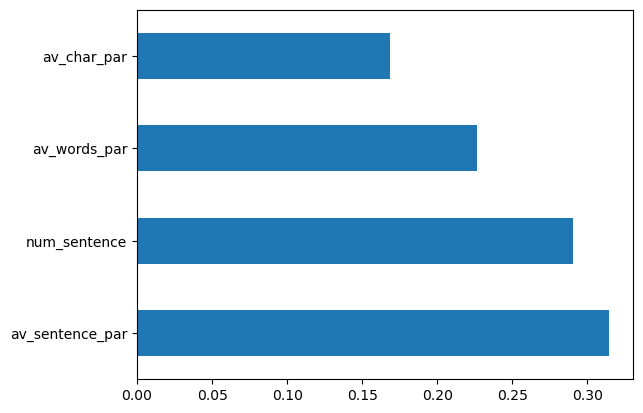

In [53]:
df_struct_aux = df_struct.copy()
exec(df_struct_aux,['num_sentence','av_sentence_par','av_words_par','av_char_par'],'gender','xgboost',remove=False,feature_type='emb')

results without tunning saved
Counter({0: 565, 4: 496, 3: 488, 1: 426, 2: 291})


'OK'

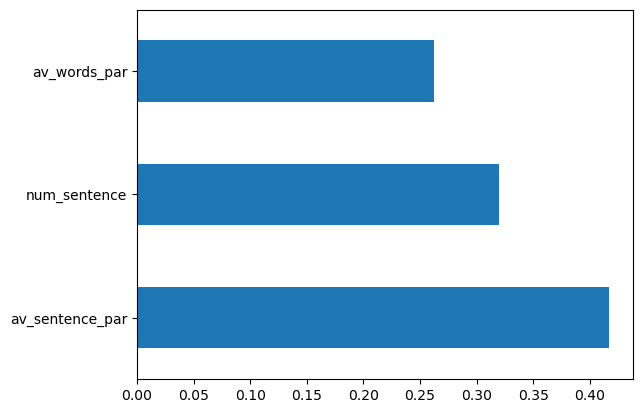

In [39]:
df_struct_aux = df_struct.copy()
exec(df_struct_aux,['av_sentence_par','num_sentence','av_words_par'],'age','xgboost',remove=False,feature_type='emb')

In [ ]:
df_struct_aux = df_struct.copy()
exec(df_struct_aux,['av_sentence_par','num_sentence','variation'],'region','xgboost',remove=True,feature_type='emb')

In [172]:
# load data for character based features analysis
def df_syntactic_based():
    data = pd.DataFrame() 
    pos_tag = nltk.UnigramTagger(cess_esp.tagged_sents())

    tags_dict = {}
    num_det = []
    num_pre = []
    num_sing = []
    num_plural = []
    num_adv = []
    num_adj = []
    num_prop = []
    num_pronouns = []
    num_past = []
    num_future = []
    num_conj = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            
            # clean text
            text = quitar_tags(text)
            text = quitar_guiones(text)
            cleaned_text = replace_multi_whitespaces(text)
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
            cleaned_text = cleaned_text.replace('\n','')
            analysis = pos_tag.tag(cleaned_text.split(' '))

            det = 0
            pre = 0
            sing = 0
            plural = 0
            adv = 0
            adj = 0
            prop = 0
            pronouns = 0
            past = 0
            future = 0
            conj = 0

            for word,tag in analysis:
                if tag != None:
                    if tag[0] == 'd':
                        det += 1
                    elif tag[0] == 'a':
                        adj += 1
                    elif tag[0] == 'c':
                        conj += 1
                    elif tag[0] == 'p':
                        pronouns += 1
                    elif tag[0] == 'n':
                        if tag[1] == 'p':
                            prop += 1
                        if tag[3] == 's':
                            sing += 1
                        elif tag[3] == 'p':
                            plural += 1
                    elif tag[0] == 'r':
                        adv += 1
                    elif (tag[0] == 'v' and tag[3] == 'f'):
                        future += 1
                    elif (tag[0] == 'v' and tag[3] == 's'):
                        past += 1
                    elif tag[0] == 's':
                        pre += 1

            
            num_det.append(det)
            num_pre.append(pre)
            num_sing.append(sing)
            num_plural.append(plural)
            num_adv.append(adv)
            num_adj.append(adj)
            num_prop.append(prop)
            num_pronouns.append(pronouns)
            num_past.append(past)
            num_future.append(future)
            num_conj.append(conj)

    for k,v in tags_dict.items():
        data[k] = v
    
    data['num_det'] = num_det
    data['num_pre'] = num_pre
    data['num_sing'] = num_sing
    data['num_plural'] = num_plural
    data['num_adv'] = num_adv
    data['num_adj'] = num_adj
    data['num_prop'] = num_prop
    data['num_pronouns'] = num_pronouns
    data['num_past'] = num_past
    data['num_future'] = num_future
    data['num_conj'] = num_conj

    return pd.concat([policia_df,data],axis=1)

In [40]:
# load data for character based features analysis
def df_syntactic_based_ratios():
    data = pd.DataFrame() 
    pos_tag = nltk.UnigramTagger(cess_esp.tagged_sents())

    tags_dict = {}
    ratio_det = []
    ratio_pre = []
    ratio_sing = []
    ratio_plural = []
    ratio_adv = []
    ratio_adj = []
    ratio_prop = []
    ratio_pronouns = []
    ratio_past = []
    ratio_future = []
    ratio_conj = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            
            # clean text
            text = quitar_tags(text)
            text = quitar_guiones(text)
            cleaned_text = replace_multi_whitespaces(text)
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
            cleaned_text = cleaned_text.replace('\n','')
            analysis = pos_tag.tag(cleaned_text.split(' '))

            num_words = len(analysis)

            det = 0
            pre = 0
            sing = 0
            plural = 0
            adv = 0
            adj = 0
            prop = 0
            pronouns = 0
            past = 0
            future = 0
            conj = 0

            for word,tag in analysis:
                if tag != None:
                    if tag[0] == 'd':
                        det += 1
                    elif tag[0] == 'a':
                        adj += 1
                    elif tag[0] == 'c':
                        conj += 1
                    elif tag[0] == 'p':
                        pronouns += 1
                    elif tag[0] == 'n':
                        if tag[1] == 'p':
                            prop += 1
                        if tag[3] == 's':
                            sing += 1
                        elif tag[3] == 'p':
                            plural += 1
                    elif tag[0] == 'r':
                        adv += 1
                    elif (tag[0] == 'v' and tag[3] == 'f'):
                        future += 1
                    elif (tag[0] == 'v' and tag[3] == 's'):
                        past += 1
                    elif tag[0] == 's':
                        pre += 1

            
            ratio_det.append(det/num_words)
            ratio_pre.append(pre/num_words)
            ratio_sing.append(sing/num_words)
            ratio_plural.append(plural/num_words)
            ratio_adv.append(adv/num_words)
            ratio_adj.append(adj/num_words)
            ratio_prop.append(prop/num_words)
            ratio_pronouns.append(pronouns/num_words)
            ratio_past.append(past/num_words)
            ratio_future.append(future/num_words)
            ratio_conj.append(conj/num_words)

    for k,v in tags_dict.items():
        data[k] = v
    
    data['ratio_det'] = ratio_det
    data['ratio_pre'] = ratio_pre
    data['ratio_sing'] = ratio_sing
    data['ratio_plural'] = ratio_plural
    data['ratio_adv'] = ratio_adv
    data['ratio_adj'] = ratio_adj
    data['ratio_prop'] = ratio_prop
    data['ratio_pronouns'] = ratio_pronouns
    data['ratio_past'] = ratio_past
    data['ratio_future'] = ratio_future
    data['ratio_conj'] = ratio_conj

    data = data_scaler(data)

    return pd.concat([policia_df,data],axis=1)

In [41]:
df_synt = df_syntactic_based_ratios()

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_synt['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_synt['region'].unique():
    region_dict[region] = i
    i += 1

df_synt['gender'] = df_synt['gender'].map(gender_dict)
df_synt['age'] = df_synt['age'].map(age_dict)
df_synt['region'] = df_synt['region'].map(region_dict)
df_synt.head()

,gender,age,region,ratio_det,ratio_pre,ratio_sing,ratio_plural,ratio_adv,ratio_adj,ratio_prop,ratio_pronouns,ratio_past,ratio_future,ratio_conj
0,1,0,0,-1.481508,2.395215,0.745993,-1.964496,-1.518417,1.387820,-0.438754,-0.235247,-0.593710,-0.022328,-1.494830
1,1,0,1,-0.072249,0.629469,0.589095,-0.585463,0.737113,0.280402,-0.438754,1.265058,-0.593710,-0.022328,-0.935901
2,1,0,0,-0.072249,0.139617,-0.967811,-0.125786,-0.916942,0.280402,-0.438754,0.322635,0.629201,-0.022328,1.096819
3,1,1,1,-2.987358,0.538756,-0.365551,-0.148486,-1.518417,0.245820,0.289428,-1.454323,-0.140780,-0.022328,-0.444329
4,1,0,2,-0.523411,0.685134,0.518327,-0.501885,-0.083080,0.184909,1.236892,-0.183625,-0.593710,-0.022328,-0.495660


results without tunning saved


'OK'

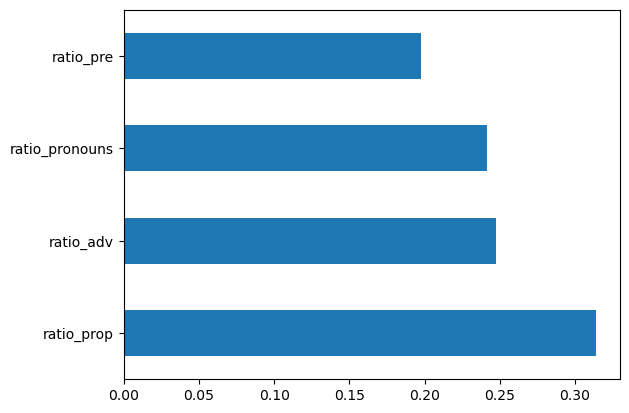

In [56]:
df_synt_aux = df_synt.copy()
exec(df_synt_aux,['ratio_pre','ratio_adv','ratio_prop','ratio_pronouns'],'gender','xgboost',remove=False,feature_type='emb')

In [45]:
df_synt_aux = df_synt.copy()
exec(df_synt_aux,['ratio_pre','ratio_plural','ratio_prop','ratio_pronouns','ratio_past','ratio_conj'],'age','svm',remove=False,feature_type='emb')

results without tunning saved
Counter({1: 500, 3: 493, 4: 480, 2: 431, 0: 362})


'OK'

In [ ]:
df_synt_aux = df_synt.copy()
exec(df_synt_aux,['ratio_det','ratio_sing','ratio_adv','ratio_prop','ratio_pronouns'],'region','xgboost',remove=False,feature_type='emb')

In [59]:
# load data for character based features analysis
def df_word_based():

    data = pd.DataFrame() 

    pos_sent,neg_sent = load_sentiment_analysis()

    num_words = []
    num_pos_words = []
    num_neg_words = []
    num_unique = []
    num_twice = []
    av_length = []
    max_length = []
    num_numbers = []
    num_greater = []
    num_smaller = []
    num_stop = []
    num_locations = []
    num_telefono = []
    num_fechas = []
    num_personas = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']

            # before cleaning, count num of tags
            tags = re.findall('LOC|NUM|TIEM|PER',text)
            counter = Counter(tags)
            for k in ['LOC','NUM','TIEM','PER']:
                if k not in counter.keys():
                    counter[k] = 0
                    
            for k,v in counter.items():
                if k == 'LOC':
                    num_locations.append(v)
                elif k == 'NUM':
                    num_telefono.append(v)
                elif k == 'TIEM':
                    num_fechas.append(v)
                elif k == 'PER':
                    num_personas.append(v)

            # remove punctuation
            # clean text
            text = quitar_tags(text)
            text = quitar_guiones(text)
            cleaned_text = replace_multi_whitespaces(text)
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
            sentences = cleaned_text.split('\n')
            words = []
            for sentence in sentences:
                words += sentence.split(' ')
            words = [w for w in words if len(w) != 0]
            words_lower = [w.lower() for w in words if len(w) != 0]

            num_words.append(len(words))

            # sentiment analysis
            pos = 0
            neg = 0
            for word in words:
                sentiment = sent_analysis(word,pos_sent,neg_sent)
                if sentiment == 'Both':
                    neg += 1
                    pos += 1
                elif sentiment == 'Positive':
                    pos += 1
                elif sentiment == 'Negative':
                    neg += 1

            num_pos_words.append(pos)
            num_neg_words.append(neg)

            # unique words
            num_unique.append(num_occurences(words,1))
            # twice occurrences
            num_twice.append(num_occurences(words,2))
            
            # max, av, >6, <3 length and num words with digits, count english words
            max_len = 0
            sum_length = 0
            digits = 0
            len_greater = 0
            len_smaller = 0
            for word in words:
                sum_length += len(word)
                if len(word) > max_len:
                    max_len = len(word)

                if len(re.findall('\d',word)) > 0:
                    digits += 1

                if len(word) > 6:
                    len_greater += 1
                elif len(word) < 3:
                    len_smaller += 1
            
            av_length.append(sum_length/len(words))
            max_length.append(max_len)
            num_numbers.append(digits)
            num_greater.append(len_greater)
            num_smaller.append(len_smaller)


            # count stop-words 
            intersection_stop = list(set(stop_words) & set(words_lower))
            num_stop.append(len(intersection_stop))

    data['num_locations'] = num_locations
    data['num_fechas'] = num_fechas
    data['num_personas'] = num_personas
    data['num_telefono'] = num_telefono
    data['num_words'] = num_words
    data['num_pos_words'] = num_pos_words
    data['num_neg_words'] = num_neg_words
    data['num_unique'] = num_unique
    data['num_twice'] = num_twice
    data['av_length'] = av_length
    data['max_length'] = max_length
    data['num_numbers'] = num_numbers
    data['num_greater'] = num_greater
    data['num_smaller'] = num_smaller
    data['num_stop'] = num_stop

    data = data_scaler(data)

    return pd.concat([policia_df,data],axis=1)         

In [60]:
df_word = df_word_based()

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_word['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_word['region'].unique():
    region_dict[region] = i
    i += 1

df_word['gender'] = df_word['gender'].map(gender_dict)
df_word['age'] = df_word['age'].map(age_dict)
df_word['region'] = df_word['region'].map(region_dict)
df_word.head()

,gender,age,region,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,num_neg_words,num_unique,num_twice,av_length,max_length,num_numbers,num_greater,num_smaller,num_stop
0,1,0,0,-0.615791,-0.761756,-0.362576,-0.442182,-1.058222,0.0,0.0,-4.082185,-0.573037,2.969268,0.570991,-0.180105,-0.906392,-1.056013,-1.554562
1,1,0,1,-0.004392,1.404843,-0.362576,-0.442182,-0.268879,0.0,0.0,0.148512,-0.573037,-0.438668,0.570991,-0.628986,-0.170123,-0.112016,0.117924
2,1,0,0,-0.615791,0.321544,-0.362576,-0.442182,-0.536569,0.0,0.0,0.148512,-0.573037,0.035130,0.570991,-0.180105,-0.573884,-0.604536,0.117924
3,1,1,1,1.218406,-0.761756,1.054997,3.779799,0.753835,0.0,0.0,0.148512,-0.573037,1.143570,0.570991,3.859824,0.946155,0.708850,-0.283473
4,1,0,2,1.218406,-0.220106,-0.362576,-0.442182,3.451330,0.0,0.0,2.968977,1.696596,-0.258276,0.570991,3.635383,3.368716,3.540841,2.258705


results without tunning saved


'OK'

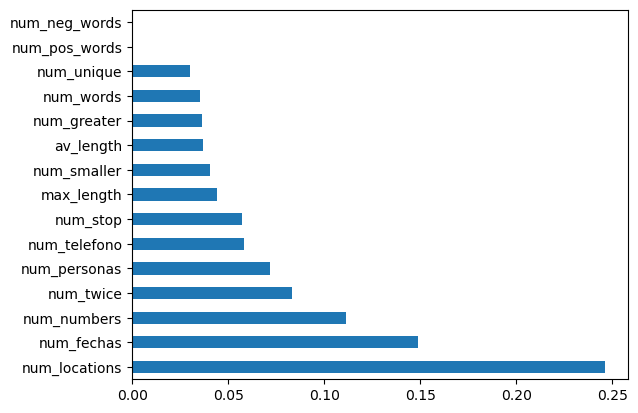

In [63]:
df_word_aux = df_word.copy()
exec(df_word_aux,['num_locations','num_fechas','num_personas','num_telefono','num_words','num_pos_words','num_neg_words','num_unique','num_twice','av_length','max_length','num_numbers','num_greater','num_smaller','num_stop'],'gender','xgboost',remove=False,feature_type='emb')

In [132]:
df_word_aux = df_word.copy()
exec(df_word_aux,['num_words','num_unique','num_numbers','num_greater','num_stop','num_locations','num_fechas'],'age','rf',remove=True)

results without tunning saved


'OK'

/Users/lunamancebo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


results without tunning saved


'OK'

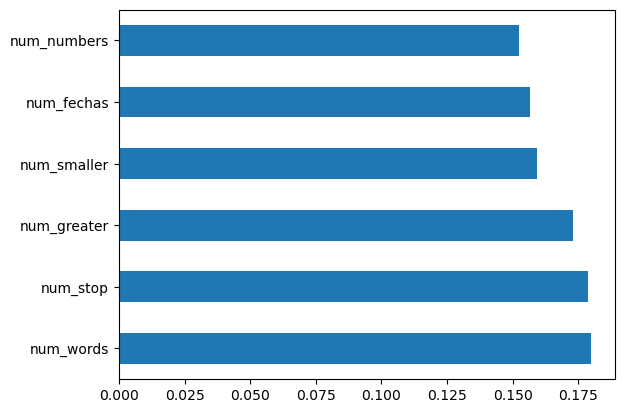

In [88]:
df_word_aux = df_word.copy()
exec(df_word_aux,['num_words','num_numbers','num_greater','num_smaller','num_stop','num_fechas'],'region','xgboost',remove=True,feature_type='emb')

### ALL STYLISTIC FEATURES

In [64]:
df_aux = pd.concat([policia_df,df_word_based(),df_syntactic_based_ratios(),df_structural_based(),df_character_based()],axis=1)
df_aux = df_aux.iloc[:,~df_aux.columns.duplicated()]
df_aux.head()

,gender,age,region,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,num_neg_words,...,ratio_future,ratio_conj,num_sentence,av_sentence_par,av_words_par,av_char_par,variation,characters,capital_letters,punctuations
0,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA,-0.615791,-0.761756,-0.362576,-0.442182,-1.058222,0.0,0.0,...,-0.022328,-1.494830,-0.943521,-0.943521,-1.055831,-1.018301,-0.212517,-1.018301,-0.612236,-0.863065
1,H,35-44,COMUNIDAD VALENCIANA,-0.004392,1.404843,-0.362576,-0.442182,-0.268879,0.0,0.0,...,-0.022328,-0.935901,-0.453163,-0.453163,-0.266230,-0.285184,-0.334263,-0.285184,-0.574428,-0.234397
2,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA,-0.615791,0.321544,-0.362576,-0.442182,-0.536569,0.0,0.0,...,-0.022328,1.096819,-0.453163,-0.453163,-0.536179,-0.535402,-0.304757,-0.535402,-0.322377,-0.593636
3,H,25-34,COMUNIDAD VALENCIANA,1.218406,-0.761756,1.054997,3.779799,0.753835,0.0,0.0,...,-0.022328,-0.444329,2.488981,2.488981,0.840561,0.912125,-0.431431,0.912125,0.837057,2.055750
4,H,35-44,PRINCIPADO DE ASTURIAS,1.218406,-0.220106,-0.362576,-0.442182,3.451330,0.0,0.0,...,-0.022328,-0.495660,3.633149,3.633149,3.405077,3.406127,0.204904,3.406127,2.273748,3.402896


In [65]:
gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_aux['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_aux['region'].unique():
    region_dict[region] = i
    i += 1

df_aux['gender'] = df_aux['gender'].map(gender_dict)
df_aux['age'] = df_aux['age'].map(age_dict)
df_aux['region'] = df_aux['region'].map(region_dict)
df_aux.head()

,gender,age,region,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,num_neg_words,...,ratio_future,ratio_conj,num_sentence,av_sentence_par,av_words_par,av_char_par,variation,characters,capital_letters,punctuations
0,1,0,0,-0.615791,-0.761756,-0.362576,-0.442182,-1.058222,0.0,0.0,...,-0.022328,-1.494830,-0.943521,-0.943521,-1.055831,-1.018301,-0.212517,-1.018301,-0.612236,-0.863065
1,1,0,1,-0.004392,1.404843,-0.362576,-0.442182,-0.268879,0.0,0.0,...,-0.022328,-0.935901,-0.453163,-0.453163,-0.266230,-0.285184,-0.334263,-0.285184,-0.574428,-0.234397
2,1,0,0,-0.615791,0.321544,-0.362576,-0.442182,-0.536569,0.0,0.0,...,-0.022328,1.096819,-0.453163,-0.453163,-0.536179,-0.535402,-0.304757,-0.535402,-0.322377,-0.593636
3,1,1,1,1.218406,-0.761756,1.054997,3.779799,0.753835,0.0,0.0,...,-0.022328,-0.444329,2.488981,2.488981,0.840561,0.912125,-0.431431,0.912125,0.837057,2.055750
4,1,0,2,1.218406,-0.220106,-0.362576,-0.442182,3.451330,0.0,0.0,...,-0.022328,-0.495660,3.633149,3.633149,3.405077,3.406127,0.204904,3.406127,2.273748,3.402896


results without tunning saved


'OK'

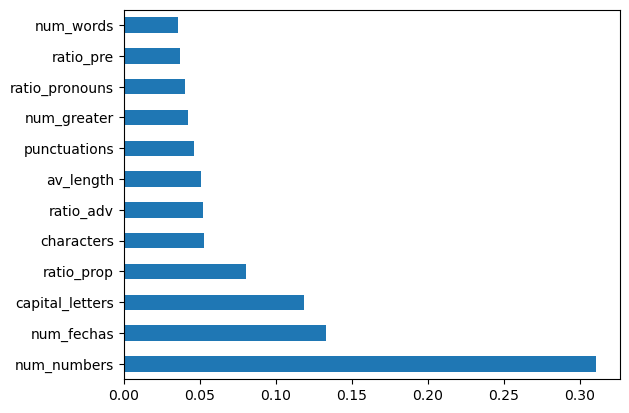

In [68]:
df = df_aux.copy()
exec(df,['characters','capital_letters','punctuations','ratio_pre','ratio_adv','ratio_prop','ratio_pronouns','num_fechas','num_words','av_length','num_numbers','num_greater'],'gender','xgboost',remove=False,feature_type='emb')

results without tunning saved


'OK'

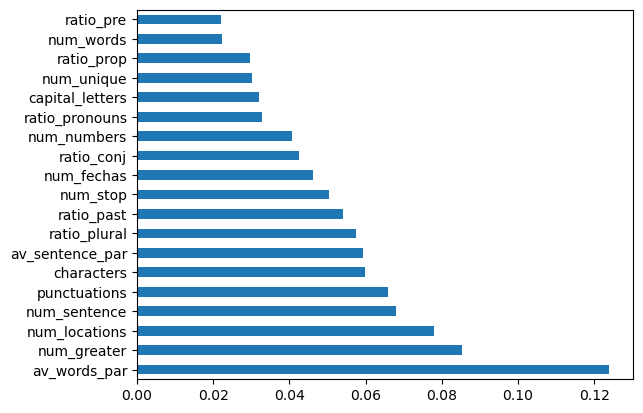

In [71]:
df = df_aux.copy()
exec(df,['characters','capital_letters','punctuations','av_sentence_par','num_sentence','av_words_par','ratio_pre','ratio_plural','ratio_prop','ratio_pronouns','ratio_past','ratio_conj','num_words','num_unique','num_numbers','num_greater','num_stop','num_locations','num_fechas'],'age','xgboost',remove=False,feature_type='emb')

/Users/lunamancebo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


results without tunning saved


/Users/lunamancebo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'OK'

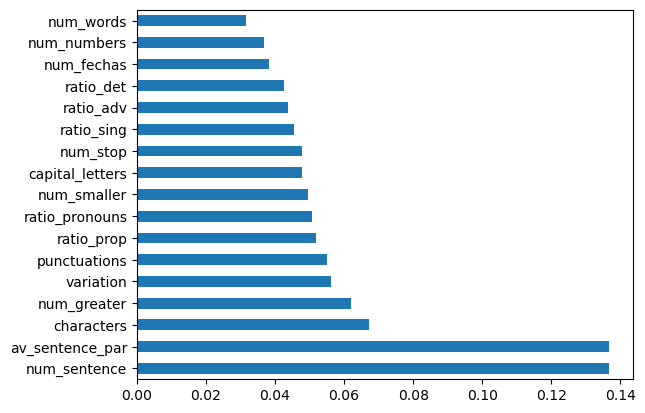

In [74]:
df = df_aux.copy()
exec(df,['characters','capital_letters','punctuations','av_sentence_par','num_sentence','variation','ratio_det','ratio_sing','ratio_adv','ratio_prop','ratio_pronouns','num_words','num_numbers','num_greater','num_smaller','num_stop','num_fechas'],'region','xgboost',remove=False,feature_type='emb')

## Word Embeddings for Denunciante

In [76]:
def load_embedding(file_path):
    embedding_vectors = {}
    with open(f'../embeddings/{file_path}','r') as f:
        first_line = f.readline().split(' ')
        for line in f.readlines()[1:]:
            row = line.split(' ')
            word = row[0]
            if word not in embedding_vectors.keys():
                embedding_vectors[word] = [float(val) for val in row[1:]]
        
    return embedding_vectors


In [77]:
df_embedding = pd.DataFrame(columns=[str(i) for i in range(300)])
print('loading embedding')
embedding_vectors = load_embedding('glove-sbwc.i25.vec')
print('embedding loaded')

loading embedding
embedding loaded


In [78]:
for file in files:
    list_sent_tweet = []

    with open(f'Atestados/{file}') as f:
        _dict = json.load(f)

        # denuncia
        text = _dict['denuncia']

        doc_emb = text
        doc_emb = quitar_guiones(doc_emb)
        sentences = doc_emb.split('\n')
        # embeddings
        for sent in sentences:
            aux = []
            # clean each sentence
            cleaned = clean_text(sent,stop_words)
            # compute vector for each word in the sentence using GloVe
            for token in word_tokenize(cleaned,language='spanish',preserve_line=True):
                vector = embedding_vectors.get(token)
                if vector is not None:
                    aux.append(vector)

            if len(aux) != 0:
                vec_sent = np.asarray(aux).mean(0)
                list_sent_tweet.append(vec_sent)
        # compute author's vector averaging tweets vectors
        vec_author = np.asarray(list_sent_tweet).mean(0)
        df_embedding.loc[len(df_embedding)] = vec_author

In [80]:
# scale SF
df = df_aux.copy()
df.drop(['gender','age','region'],axis=1,inplace=True)
scaler = MinMaxScaler(feature_range=(-1,1))
df_scaled = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

df_all = pd.concat([policia_df,df_embedding,df_scaled],axis=1)

df_emb = policia_df.join(df_embedding)

In [81]:
df_all = df_all.loc[df_all['region'] != 'República Dominicana']
df_all.reset_index(drop=True, inplace=True)

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_all['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_all['region'].unique():
    region_dict[region] = i
    i += 1

df_all['gender'] = df_all['gender'].map(gender_dict)
df_all['age'] = df_all['age'].map(age_dict)
df_all['region'] = df_all['region'].map(region_dict)
df_all.head()

,gender,age,region,0,1,2,3,4,5,6,...,ratio_future,ratio_conj,num_sentence,av_sentence_par,av_words_par,av_char_par,variation,characters,capital_letters,punctuations
0,1,0,0,-0.015524,0.065935,-0.058350,0.004893,-0.008343,-0.003111,0.025299,...,-1.0,-0.546638,-0.965812,-0.965812,-0.979749,-0.977291,-0.910077,-0.977291,-0.996181,-0.985637
1,1,0,1,0.000629,0.083598,0.045772,0.011202,-0.005373,0.170438,0.046553,...,-1.0,-0.413921,-0.914530,-0.914530,-0.898045,-0.903898,-0.926248,-0.903898,-0.993317,-0.935368
2,1,0,0,0.023928,0.080859,0.023696,0.099967,-0.065307,-0.050397,0.216720,...,-1.0,0.068742,-0.914530,-0.914530,-0.925978,-0.928948,-0.922329,-0.928948,-0.974224,-0.964093
3,1,1,1,0.106350,-0.052352,0.058586,0.069384,-0.045778,-0.042051,0.043624,...,-1.0,-0.297199,-0.606838,-0.606838,-0.783520,-0.784034,-0.939154,-0.784034,-0.886396,-0.752244
4,1,0,2,0.019442,-0.008899,0.080017,0.045510,-0.162727,0.118048,0.119304,...,-1.0,-0.309387,-0.487179,-0.487179,-0.518156,-0.534356,-0.854633,-0.534356,-0.777566,-0.644524


In [82]:
df_emb = df_emb.loc[df_emb['region'] != 'República Dominicana']
df_emb.reset_index(drop=True, inplace=True)

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_emb['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_emb['region'].unique():
    region_dict[region] = i
    i += 1

df_emb['gender'] = df_emb['gender'].map(gender_dict)
df_emb['age'] = df_emb['age'].map(age_dict)
df_emb['region'] = df_emb['region'].map(region_dict)
df_emb.head()

,gender,age,region,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,1,0,0,-0.015524,0.065935,-0.058350,0.004893,-0.008343,-0.003111,0.025299,...,-0.035895,0.051085,-0.012862,-0.161206,0.037098,0.071675,0.125228,-0.110935,0.104955,0.001244
1,1,0,1,0.000629,0.083598,0.045772,0.011202,-0.005373,0.170438,0.046553,...,-0.078893,0.090042,0.019515,-0.021092,0.147205,0.107504,0.026894,0.001540,0.048155,-0.068764
2,1,0,0,0.023928,0.080859,0.023696,0.099967,-0.065307,-0.050397,0.216720,...,-0.012825,0.050679,-0.020423,-0.165699,0.154780,-0.055210,0.051686,-0.054746,0.077717,-0.068374
3,1,1,1,0.106350,-0.052352,0.058586,0.069384,-0.045778,-0.042051,0.043624,...,-0.024657,0.031756,0.015692,-0.079534,0.131626,0.056988,0.071570,-0.029113,0.105175,-0.004498
4,1,0,2,0.019442,-0.008899,0.080017,0.045510,-0.162727,0.118048,0.119304,...,-0.005773,0.055426,0.000523,-0.083311,0.087902,0.015602,0.062471,-0.086706,0.020434,-0.005470


results without tunning saved


'OK'

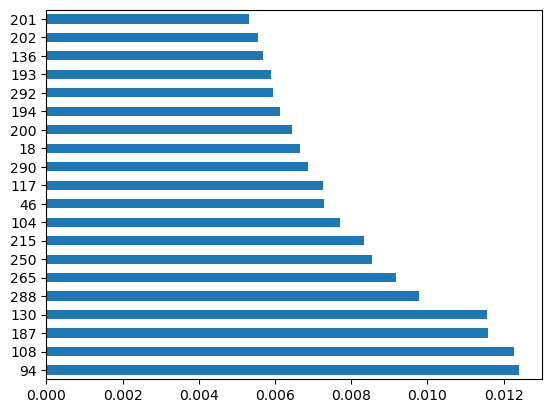

In [85]:
df = df_emb.copy()
exec(df,None,'gender','xgboost',remove=False,feature_type='emb')

In [133]:
def exec(df,features,target_col,model,remove,feature_type):
    # remove outliers
    if features is None:
        features = [str(i) for i in range(300)]
    else:
        if remove:
            # remove outliers
            for f in features:
                Q1 = np.percentile(df[f],25,method = 'midpoint')
                Q3 = np.percentile(df[f],75,method = 'midpoint')
                IQR = Q3 - Q1
                upper = Q3 + 1.5*IQR
                lower = Q1 - 1.5*IQR
                drop_index = np.where(df[f]>=upper) + np.where(df[f]<=lower)
                df.drop(drop_index[0], inplace=True)
                df.reset_index(drop=True,inplace=True)

        if feature_type == 'all':
            features += [str(i) for i in range(300)]

    for t in df[target_col].unique():
        if len(df.loc[df[target_col] == t]) < 2:
            df = df.loc[df[target_col] != t]
            df.reset_index(drop=True,inplace=True)

    target = df[target_col]
    col_drop = [f for f in df.columns if f not in features]
    df.drop(col_drop,axis=1,inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(df, target, stratify=target, shuffle=True,test_size=0.2,random_state=109)

    if target_col == 'gender':
        average = 'binary'
        objective = 'binary:logistic'
    else:
        average = 'weighted'
        objective = 'multi:softmax'

    if model == 'svm':
        clf = svm.SVC() 
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        save_results(y_test,y_pred,average,remove=remove)
        print('results without tunning saved')

        params = "{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"
        clf = svm.SVC(C=10,gamma=0.1,kernel='rbf')
        clf.fit(X_train, y_train)
    
    elif model == 'rf':
        clf = RandomForestClassifier()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        save_results(y_test,y_pred,average,remove=remove)
        print('results without tunning saved')

        params="{'criterion': 'gini', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}"
        clf = RandomForestClassifier(criterion='gini',max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=4,n_estimators=200)
        clf.fit(X_train, y_train)
        
    elif model == 'xgboost':
        clf = xgb.XGBRFClassifier(objective=objective)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        save_results(y_test,y_pred,average,remove=remove)
        print('results without tunning saved')

        params = "{'learning_rate': 0.01, 'n_estimators': 100, 'reg_lambda': 0.5}"
        clf = xgb.XGBRFClassifier(objective=objective,learning_rate=0.01,n_estimators=100,reg_lambda=0.5)
        clf.fit(X_train, y_train)
        
    y_pred = clf.predict(X_test)
    save_results(y_test,y_pred,average,tunning=True,params=params,remove=remove)

    return 'OK'


results without tunning saved


'OK'

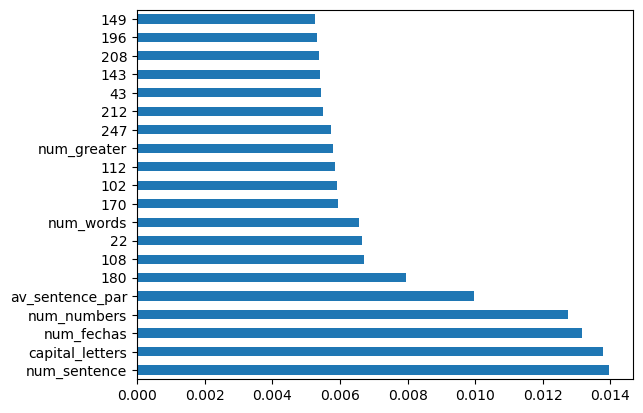

In [88]:
df = df_all.copy()
exec(df,['characters','capital_letters','punctuations','av_sentence_par','num_sentence','ratio_det','ratio_pre','num_words','av_length','num_numbers','num_greater','num_fechas'],'gender','xgboost',remove=True,feature_type='all')

In [132]:
df = df_all.copy()
exec(df,['characters','capital_letters','punctuations','av_sentence_par','num_sentence','av_words_par','num_det','num_pre','num_sing','num_plural','num_adj','num_pronouns','num_adv','num_conj','num_words','num_unique','num_numbers','num_greater','num_stop','num_locations','num_fechas'],'age','xgboost',remove=True,feature_type='all')

results without tunning saved


'OK'

In [73]:
df = df_all.copy()
exec(df,['characters','capital_letters','punctuations','av_sentence_par','num_sentence','variation','num_det','num_pronouns','num_adv','num_conj','num_words','num_numbers','num_greater','num_smaller','num_stop','num_fechas'],'region','xgboost',remove=True,feature_type='all')

NameError: name 'df_all' is not defined